In [1]:
import scvelo as scv
import dynamo as dyn
import numpy as np
from anndata import AnnData
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix,issparse
import pandas as pd
import seaborn as sns

import argparse
import random

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

import sys
sys.path.append('..')

method = ''
from utils.g2g_model_Fisher import *
from utils.utils import *
from utils.RKHS import *

C:\Users\dell\anaconda3\lib\site-packages\setuptools_scm\_integration\setuptools.py:31: RuntimeWarning: 
ERROR: setuptools==59.5.0 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the build tools

  warnings.warn(


In [2]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

2.4.0
11.8
True
1
0


In [3]:
data_path = 'data/'
data_name = 'EG_ab'

adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)

[k_nei, K, L] = [10, 2, 10]
# metric = 'minkowski'
metric = 'euclidean'
# metric = 'cosine'
# metric = 'correlation'
norm = 'none'
# norm = 'standard'
# norm = 'minmax'

result_path = 'results/'+data_name+','+norm+','+metric+','+method+','+str([k_nei,K,L])+'/'
figure_path = 'figures/'
cmap = plt.colormaps['Spectral']

In [4]:
import os

folder = os.path.exists(result_path)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(result_path)            #makedirs 创建文件时如果路径不存在会创建这个路径

In [5]:
#-------data preprocessing
adata=adata0.copy()

scv.pp.neighbors(adata, n_neighbors=k_nei)
scv.pp.pca(adata,n_comps=50)
scv.pp.moments(adata, n_pcs=50, n_neighbors=k_nei)

computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [6]:
gene_arr = adata.var.index.values
X_pca = adata.obsm['X_pca']
X_umap = adata.obsm['X_umap']
# cell_vpt = adata.obs['velocity_pseudotime'].values#adata0.obs['latent_time'].values#
cell_vpt = adata.obs['palantir_pseudotime']
Xs = adata.layers['Ms']#adata.X.A#
A = kneighbors_graph(Xs, k_nei, mode='connectivity', include_self=True)
ppt_ind = np.argsort(adata.obs['palantir_pseudotime'])

Text(0, 0.5, 'Expression')

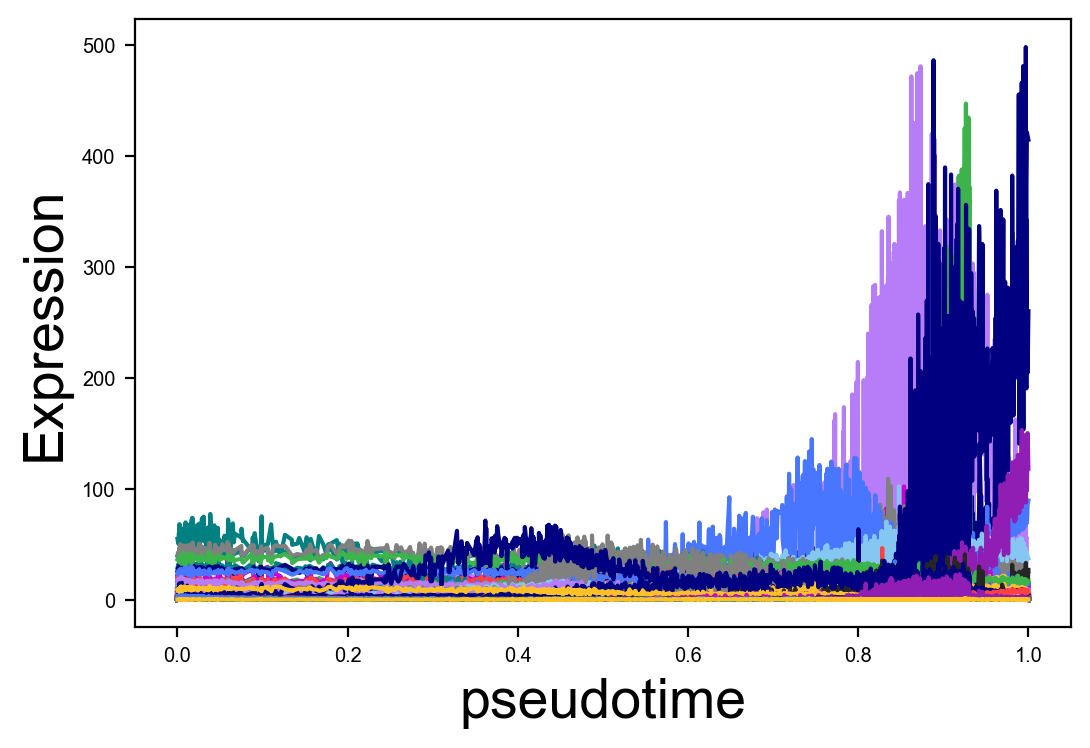

In [7]:
plt.plot(adata.obs['palantir_pseudotime'][ppt_ind],Xs[ppt_ind])
plt.xlabel('pseudotime',fontsize=20)
plt.ylabel('Expression',fontsize=20)

In [8]:
Xs_max = np.max(Xs,axis=0)

Text(0, 0.5, 'Expression')

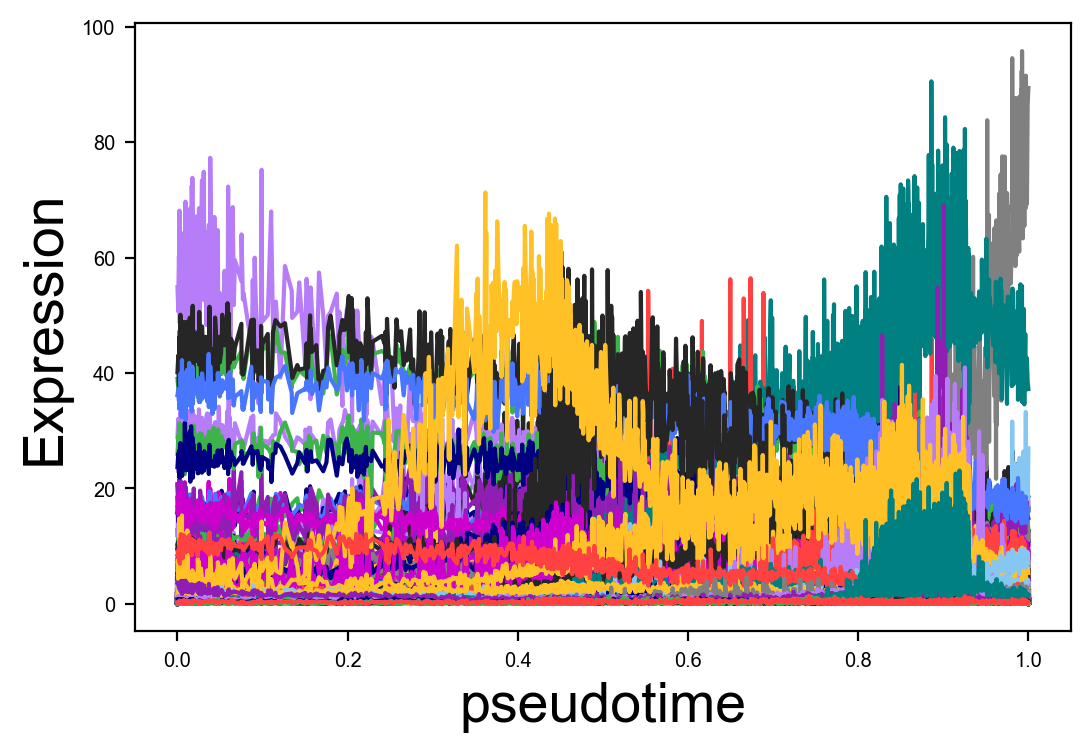

In [9]:
plt.plot(adata.obs['palantir_pseudotime'][ppt_ind],Xs[ppt_ind][:,np.where(Xs_max<100)[0]])
plt.xlabel('pseudotime',fontsize=20)
plt.ylabel('Expression',fontsize=20)

In [10]:
X = Xs[:,np.where(Xs_max<100)[0]]

In [11]:
row = np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()
col = A.indices
w_val = np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])
adj_val = np.ones(col.shape)
A_mat = csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
W_mat = csr_matrix((w_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))

In [12]:
dc = np.mean(w_val)

cell_nei = adata.uns['neighbors']['indices']
nei_w = []
rho_arr = []
for ni in adata.uns['neighbors']['indices']:
    dij=np.array([np.linalg.norm(X_pca[int(ni[0]),:]-X_pca[int(i),:]) for i in ni[1:]])
    
    rho=np.sum(np.exp(-dij**2/dc**2))
#     rho=np.exp(np.sum(-dij**2/dc**2))
    nei_w.append(np.exp(-dij**2/dc**2)/np.sum(np.exp(-dij**2/dc**2)))
#     print(dij)
#     print(np.exp(-dij**2/dc**2)/np.sum(np.exp(-dij**2/dc**2)))
    rho_arr.append(rho)
rho_arr=np.array(rho_arr)/np.amax(rho_arr)
nei_w=np.array(nei_w)
nei_w=np.hstack((np.ones((nei_w.shape[0],1)),nei_w))/2

def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return X_s

In [13]:
epochs = 200
nsamples = 5
learning_rate = 1e-3
seed = 0
# n_workers = 4

if seed is not None:
    reset_seeds(seed)

A = A_mat
A = A.astype(np.float32)
X = X.astype(np.float32)
z = np.zeros(adata.n_obs)

n = A.shape[0]
train_nodes, val_nodes = train_test_split(n, train_ratio=1.0)
A_train = A[train_nodes, :][:, train_nodes]
X_train = X[train_nodes]
z_train = z[train_nodes]
A_val = A[val_nodes, :][:, val_nodes]
X_val = X[val_nodes]
z_val = z[val_nodes]

train_data = AttributedGraph(A_train, X_train, z_train, K)
val_data = AttributedGraph(A_val, X_val, z_val, K)

encoder = Encoder(X.shape[1], L)
# encoder = torch.load(result_path+'encoder.pt')

In [14]:
optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)

iterations = epochs #// n_workers
dataset = GraphDataset(train_data, nsamples, iterations)
loader = DataLoader(
    dataset,
    batch_size=1,
#     num_workers=n_workers,
    worker_init_fn=reset_seeds,
    collate_fn=lambda args: args,
)

In [15]:
for batch_idx, data in enumerate(loader):
    encoder.train()
    optimizer.zero_grad()

    loss = encoder.compute_loss(data[0][0],data[0][1],data[0][2],data[0][3],data[0][4],data[0][5])
    if batch_idx% 10 == 0:
        print(batch_idx,loss)
    loss.backward()
    optimizer.step()

torch.save(encoder,result_path+'encoder_nhg0.pt')

0 tensor(3.7665e+09, grad_fn=<DivBackward0>)
10 tensor(85012192., grad_fn=<DivBackward0>)
20 tensor(65855572., grad_fn=<DivBackward0>)
30 tensor(59376512., grad_fn=<DivBackward0>)
40 tensor(56428736., grad_fn=<DivBackward0>)
50 tensor(54380248., grad_fn=<DivBackward0>)
60 tensor(53229516., grad_fn=<DivBackward0>)
70 tensor(51704176., grad_fn=<DivBackward0>)
80 tensor(49364096., grad_fn=<DivBackward0>)
90 tensor(48022712., grad_fn=<DivBackward0>)
100 tensor(47908280., grad_fn=<DivBackward0>)
110 tensor(46230336., grad_fn=<DivBackward0>)
120 tensor(45195200., grad_fn=<DivBackward0>)
130 tensor(44551412., grad_fn=<DivBackward0>)
140 tensor(42996308., grad_fn=<DivBackward0>)
150 tensor(42924232., grad_fn=<DivBackward0>)
160 tensor(41575252., grad_fn=<DivBackward0>)
170 tensor(41029280., grad_fn=<DivBackward0>)
180 tensor(41474600., grad_fn=<DivBackward0>)
190 tensor(40010572., grad_fn=<DivBackward0>)


In [16]:
mu, sigma = encoder(torch.tensor(X))
mu_learned = mu.detach().numpy()
sigma_learned = sigma.detach().numpy()

Fisher_g=np.zeros((X.shape[0],L*2,L*2))
for i in range(X.shape[0]):
    for j in range(L):
        Fisher_g[i,j,j]=1/sigma_learned[i,j]**2
        Fisher_g[i,L+j,L+j]=2/sigma_learned[i,j]**2

Fisher_g_diag = np.zeros([X.shape[0],L*2])
for i in range(X.shape[0]):
    Fisher_g_diag[i] = np.diag(Fisher_g[i])

In [17]:
cRc_arr=[]
cRc_arr_eu=[]

for inds in np.split(A.indices, A.indptr)[1:-1]:
    self_ind=inds[0]
    cRc=0
    cRc_eu=0
    for nei_k in range(1,len(inds)):

        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
        dFi=Fisher_dist(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])
        dWa=wasserstein_distance(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])

        cRc+=1-dWa/dFi
        cRc_eu+=1-dWa/dEu

    cRc_arr.append(cRc/len(inds))
    cRc_arr_eu.append(cRc_eu/len(inds))
crc = np.array(cRc_arr)
crc_eu = np.array(cRc_arr_eu)
crc_smooth = smooth_func(crc_eu)

In [18]:
# np.save(result_path+'crc',crc)
# np.save(result_path+'crc_eu',crc_eu)
np.save(result_path+'crc_smooth_nhg0',crc_smooth)

In [19]:
X_plt = -X_umap[:,0]
Y_plt = X_umap[:,1]

In [20]:
cl = 'clusters'
    
cl_name = np.unique(adata.obs[cl])
palette = sns.color_palette("RdBu_r",n_colors=cl_name.shape[0])
# palette = sns.color_palette(n_colors=cl_name.shape[0])
cln = np.array(adata.obs[cl])
cl_vpt = np.zeros(cl_name.shape[0])
for i in range(cl_name.shape[0]):
    if data_name=='DG_bin':
        cl_vpt[i] = np.mean(cell_ppt[cln==cl_name[i]])
    else:
        cl_vpt[i] = np.mean(cell_vpt[cln==cl_name[i]])
cl_vpt_ind = np.argsort(cl_vpt)
cl_name_vpt = cl_name[cl_vpt_ind]

cln_vpt_ind = np.zeros(cln.shape[0],dtype=int)
clx = np.zeros(cln.shape[0])
clc = np.array([palette[0]]*cln.shape[0])
cl_ind = np.zeros(cl_name.shape[0])
i_ind = 0
for i in range(cl_name.shape[0]):
    cli_ind = np.argwhere(cln==cl_name_vpt[i])[:,0]
    ni = cli_ind.shape[0]
    cln_vpt_ind[i_ind:i_ind+ni] = cli_ind
    clx[cli_ind] = i
    clc[cli_ind] = palette[i]
    cl_ind[i] = i_ind+ni/2
    i_ind += ni
cln_vpt = cln[cln_vpt_ind]

In [21]:
import networkx as nx
G = nx.Graph(A)
G.remove_edges_from(nx.selfloop_edges(G))
pos = np.array([X_plt,Y_plt]).T

In [22]:
X_min = np.min(X_plt)
X_max = np.max(X_plt)
Y_min = np.min(Y_plt)
Y_max = np.max(Y_plt)
X_len = (X_max-X_min)/5
Y_len = (Y_max-Y_min)/5
wid = min(X_len,Y_len)/30
X_ori = X_min-wid*10
Y_ori = Y_min+wid*20

(-16.836888341903688,
 16.762929182052613,
 -8.511011838912964,
 11.547290563583374)

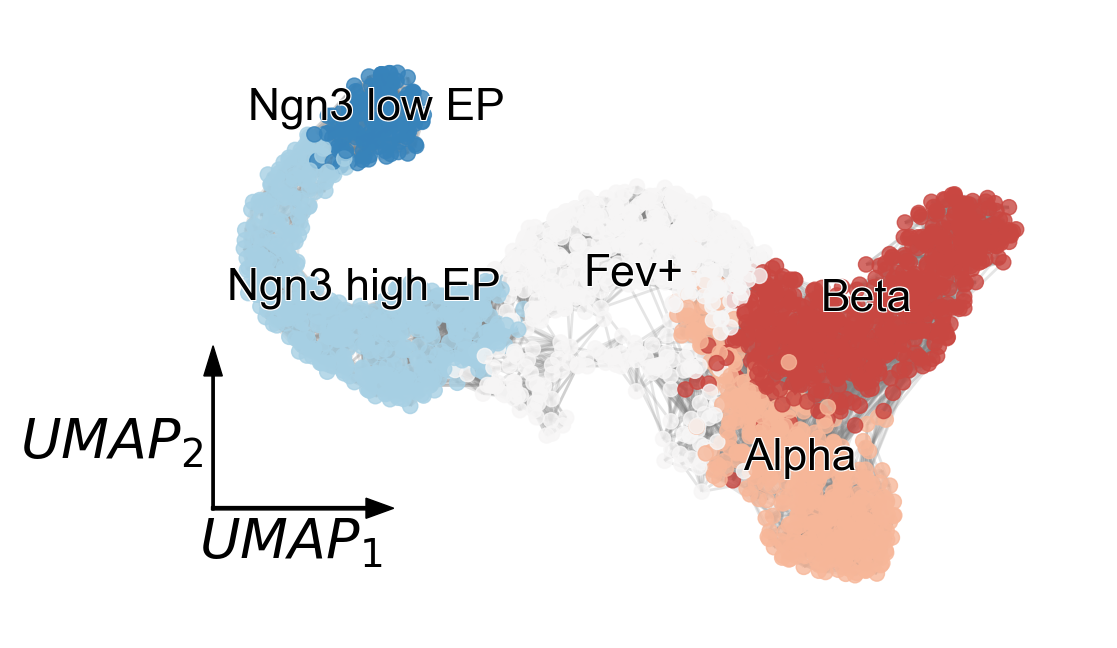

In [23]:
tk = 0.03
fontsize = 16

nx.draw_networkx_nodes(G,pos=pos,node_color=clc,node_size=30,alpha=0.8)
nx.draw_networkx_edges(G,pos=pos,width=1,alpha=0.2,edge_color='gray')

for i in range(len(cl_name)):
    cl_ind = adata.obs[cl]==cl_name[i]
    cl_pos = np.mean(pos[cl_ind],axis=0)
    plt.text(cl_pos[0]-tk,cl_pos[1]-tk,cl_name[i],fontsize=fontsize,ha='center',color='w')
    plt.text(cl_pos[0]+tk,cl_pos[1]-tk,cl_name[i],fontsize=fontsize,ha='center',color='w')
    plt.text(cl_pos[0]-tk,cl_pos[1]+tk,cl_name[i],fontsize=fontsize,ha='center',color='w')
    plt.text(cl_pos[0]+tk,cl_pos[1]+tk,cl_name[i],fontsize=fontsize,ha='center',color='w')
    plt.text(cl_pos[0],cl_pos[1],cl_name[i],fontsize=fontsize,ha='center')
    
plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=6*wid,head_length=9*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len*4/3,width=wid*3/4,color='black',head_width=6*wid,head_length=9*wid)
plt.text(X_ori+X_len/2,Y_ori-wid*15,'$UMAP_1$',fontsize=20,ha='center',weight='bold')
plt.text(X_ori-wid*33,Y_ori+Y_len/2,'$UMAP_2$',fontsize=20,ha='center',weight='bold')

plt.axis('off')
#plt.savefig(figure_path+'3a.png',dpi=600,bbox_inches='tight')

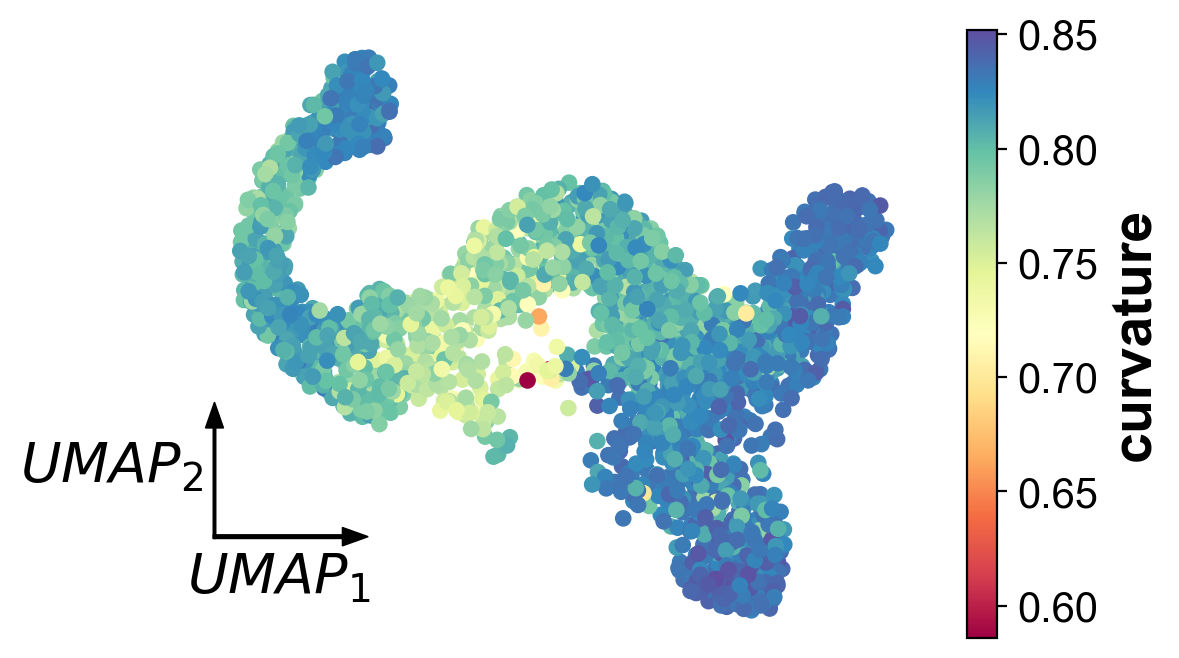

In [24]:
plt.scatter(X_plt,Y_plt,c=crc_smooth,s=30,cmap=cmap)
plt.axis('off')

plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid,head_length=10*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=7*wid,head_length=7*wid)
plt.text(X_ori+X_len/2,Y_ori-wid*15,'$UMAP_1$',fontsize=20,ha='center',weight='bold')
plt.text(X_ori-wid*40,Y_ori+Y_len/2,'$UMAP_2$',fontsize=20,ha='center',weight='bold')

clb=plt.colorbar()
clb.ax.set_ylabel('curvature',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)
# plt.savefig(figure_path+'5c1.png',dpi=600,bbox_inches='tight')
plt.show()

In [25]:
max_fs = np.zeros(X.shape[0])
max2_fs = np.zeros(X.shape[0])
max3_fs = np.zeros(X.shape[0])
for i in range(X.shape[0]):
    fsi = Fisher_g_diag[i,:10]
    fsi_sorted = np.sort(fsi)
    max_fs[i] = fsi_sorted[-1]
    max2_fs[i] = fsi_sorted[-2]
    max3_fs[i] = fsi_sorted[-3]

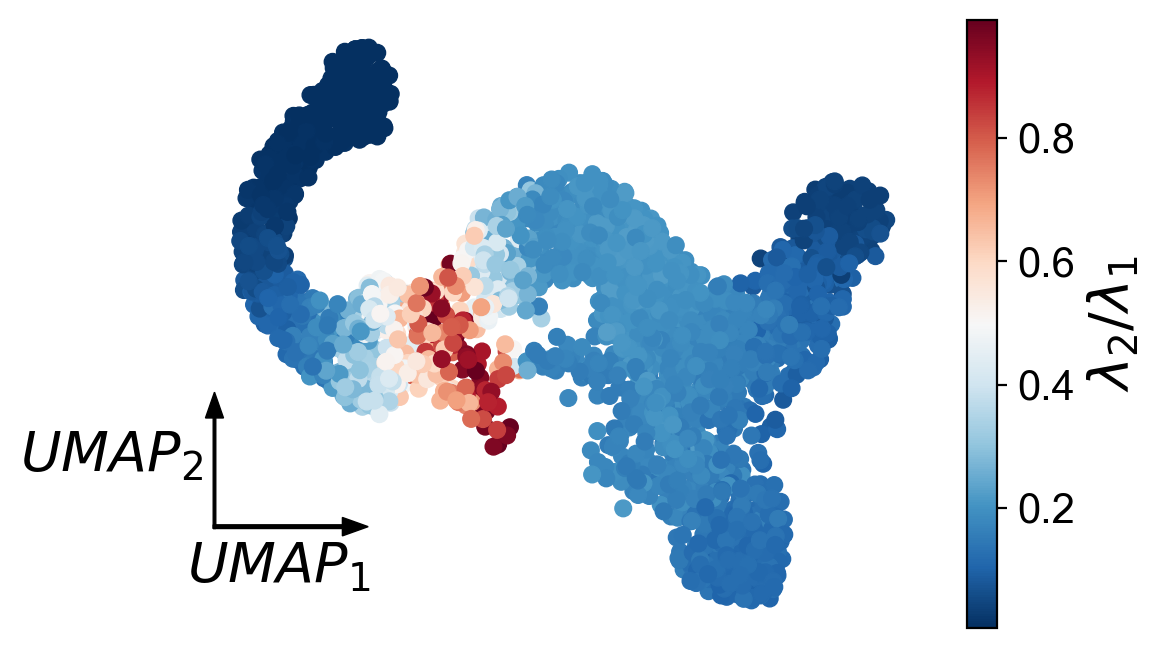

In [26]:
plt.scatter(X_plt,Y_plt,c=max2_fs/max_fs)
plt.axis('off')

plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid,head_length=10*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=7*wid,head_length=7*wid)
plt.text(X_ori+X_len/2,Y_ori-wid*15,'$UMAP_1$',fontsize=20,ha='center',weight='bold')
plt.text(X_ori-wid*40,Y_ori+Y_len/2,'$UMAP_2$',fontsize=20,ha='center',weight='bold')
clb=plt.colorbar()
clb.ax.set_ylabel('$\lambda_2/\lambda_1$',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)

#plt.savefig(figure_path+data_name+'_ratio.png',dpi=600,bbox_inches='tight')
plt.show()

# plt.scatter(X_plt[:,0],X_plt[:,1],c=max3_fs/max2_fs)
# plt.colorbar()
# plt.show()

# plt.scatter(X_plt[:,0],X_plt[:,1],c=max3_fs/max_fs)
# plt.colorbar()
# plt.show()